In [2]:
if 'google.colab' in str(get_ipython()):
    !pip uninstall tensorflow -y
    !pip install tensorflow==2.3.1 tensorflow-quantum neptune-client
    !rm -rf quantum-gans
    !git clone https://github.com/WiktorJ/quantum-gans
    !cd quantum-gans; pip install .
    neptun_token = "" # put manually for the time being
else:
    import subprocess
    def get_var(varname):
        CMD = 'echo $(source ~/.bash_profile; echo $%s)' % varname
        p = subprocess.Popen(CMD, stdout=subprocess.PIPE, shell=True, executable='/bin/bash')
        return p.stdout.readlines()[0].strip()
    neptun_token = get_var('NEPTUNE_API_TOKEN').decode("utf-8") 

In [3]:
%load_ext autoreload
%autoreload 2

In [2]:
import io
import math
import json
import neptune
import tensorflow as tf

import cirq
import numpy as np
from qsgenerator.utils import map_to_radians
from qsgenerator.qugans import circuits
from qsgenerator.resolvers import resolve_all
from qsgenerator.qugans.training import Trainer
from qsgenerator.phase.circuits import PhaseCircuitBuilder
from qsgenerator.phase.constants import z1_theta, z2_theta
from qsgenerator.phase.analitical import  get_ground_state_for_g
from qsgenerator.states.simple_state_circuits import build_x_rotation_state
from qsgenerator.states.simple_rotation_generators import get_binary_x_rotation_provider, get_arcsin_x_rotation_provider
from qsgenerator.phase.analitical import construct_hamiltonian, get_theta_v, get_theta_w, get_theta_r, get_g_parameters_provider
from qsgenerator.evaluators.circuit_evaluator import CircuitEvaluator

In [5]:
use_neptune = False

In [6]:
generator_layers = 5
discriminator_layers = 5
data_bus_size = 5
generator_bath_size = 0
discriminator_bath_size = 0

In [8]:
real_phase = True
generic_generator = True
all_layers_labeling = False
full_layer_labeling = False
use_gen_label_qubit = True
use_disc_label_qubit = True
zxz = True
all_gates_parametrized = True
fixed_gates = {}
# fixed_gates = {"z1": z1_theta}

In [9]:
gen, gs, disc, ds, ls, data_qubits, out_qubit = circuits.build_gan_circuits(
    generator_layers, 
    discriminator_layers, 
    data_bus_size, 
    generator_bath_size = generator_bath_size,
    discriminator_bath_size = discriminator_bath_size,
    all_layers_labeling=all_layers_labeling,
    full_layer_labeling=full_layer_labeling,
    use_gen_label_qubit=use_gen_label_qubit,
    use_disc_label_qubit=use_disc_label_qubit)

In [10]:
if not generic_generator:
    builder = PhaseCircuitBuilder(all_gates_parametrized=all_gates_parametrized)
    gen, gs, symbols_dict_gen = builder.build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)
else:
    symbols_dict_gen = {}

In [11]:
gen, gs = resolve_all(gen, gs, symbols_dict_gen, fixed_gates)

In [12]:
if real_phase:
    builder = PhaseCircuitBuilder(all_gates_parametrized=False)
    real, real_symbols, symbols_dict_real = builder.build_ground_state_circuit(qubits=data_qubits)
else:
    real, real_symbols, symbols_dict_real = build_x_rotation_state(qubits=data_qubits)

In [13]:
pure_gen = gen.copy()
gen.append([disc])

In [14]:
pure_real = real.copy()
real.append([disc])

In [15]:
print("REAL GROUND STATE")
pure_real

REAL GROUND STATE


(0, 2): ───H───@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │
(0, 3): ───────X───Z───Ry(theta_r)───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                   │                                       │
(0, 4): ─────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                   │                                       │
(0, 5): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────
                                                                                                                                                                                                                   │                                       │
(0, 6): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───

In [16]:
print("GENERATOR")
pure_gen

GENERATOR


(0, 2): ───Rx(g0)───Rz(g6)────ZZ──────────────────────────Rx(g17)───Rz(g23)───ZZ────────────────Rx(g34)───Rz(g40)───ZZ────────────────Rx(g51)───Rz(g57)───ZZ────────────────Rx(g68)───Rz(g74)───ZZ────────────────
                              │                                               │                                     │                                     │                                     │
(0, 3): ───Rx(g1)───Rz(g7)────ZZ^g12────ZZ────────────────Rx(g18)───Rz(g24)───ZZ^g29───ZZ───────Rx(g35)───Rz(g41)───ZZ^g46───ZZ───────Rx(g52)───Rz(g58)───ZZ^g63───ZZ───────Rx(g69)───Rz(g75)───ZZ^g80───ZZ───────
                                        │                                              │                                     │                                     │                                     │
(0, 4): ───Rx(g2)───Rz(g8)────ZZ────────ZZ^g15────────────Rx(g19)───Rz(g25)───ZZ───────ZZ^g32───Rx(g36)───Rz(g42)───ZZ───────ZZ^g49───Rx(g53)───Rz(g59)───ZZ───────ZZ^g66───Rx(g70)───Rz(g76)───ZZ───────ZZ^g83───
                              │                                               │                                     │                                     │                                     │
(0, 5): ───Rx(g3)───Rz(g9)────ZZ^g13─────────────ZZ───────Rx(g20)───Rz(g26)───ZZ^g30───ZZ───────Rx(g37)───Rz(g43)───ZZ^g47───ZZ───────Rx(g54)───Rz(g60)───ZZ^g64───ZZ───────Rx(g71)───Rz(g77)───ZZ^g81───ZZ───────
                                                 │                                     │                                     │                                     │                                     │
(0, 6): ───Rx(g4)───Rz(g10)─────────────ZZ───────ZZ^g16───Rx(g21)───Rz(g27)───ZZ───────ZZ^g33───Rx(g38)───Rz(g44)───ZZ───────ZZ^g50───Rx(g55)───Rz(g61)───ZZ───────ZZ^g67───Rx(g72)───Rz(g78)───ZZ───────ZZ^g84───
                                        │                                     │                                     │                                     │                                     │
(0, 7): ───Rx(l)────Rx(g5)────Rz(g11)───ZZ^g14────────────Rx(g22)───Rz(g28)───ZZ^g31────────────Rx(g39)───Rz(g45)───ZZ^g48────────────Rx(g56)───Rz(g62)───ZZ^g65────────────Rx(g73)───Rz(g79)───ZZ^g82────────────

In [17]:
print("DISCRIMINATOR")
disc

DISCRIMINATOR


(0, 0): ───Rx(d0)───Rz(d7)─────────────ZZ────────────────Rx(d20)───Rz(d27)───ZZ────────────────Rx(d40)───Rz(d47)───ZZ────────────────Rx(d60)───Rz(d67)───ZZ────────────────Rx(d80)───Rz(d87)───ZZ────────────────
                                       │                                     │                                     │                                     │                                     │
(0, 1): ───Rx(l)────Rx(d1)────Rz(d8)───ZZ^d14───ZZ───────Rx(d21)───Rz(d28)───ZZ^d34───ZZ───────Rx(d41)───Rz(d48)───ZZ^d54───ZZ───────Rx(d61)───Rz(d68)───ZZ^d74───ZZ───────Rx(d81)───Rz(d88)───ZZ^d94───ZZ───────
                                                │                                     │                                     │                                     │                                     │
(0, 2): ───Rx(d2)───Rz(d9)────ZZ────────────────ZZ^d17───Rx(d22)───Rz(d29)───ZZ───────ZZ^d37───Rx(d42)───Rz(d49)───ZZ───────ZZ^d57───Rx(d62)───Rz(d69)───ZZ───────ZZ^d77───Rx(d82)───Rz(d89)───ZZ───────ZZ^d97───
                              │                                              │                                     │                                     │                                     │
(0, 3): ───Rx(d3)───Rz(d10)───ZZ^d15───ZZ────────────────Rx(d23)───Rz(d30)───ZZ^d35───ZZ───────Rx(d43)───Rz(d50)───ZZ^d55───ZZ───────Rx(d63)───Rz(d70)───ZZ^d75───ZZ───────Rx(d83)───Rz(d90)───ZZ^d95───ZZ───────
                                       │                                              │                                     │                                     │                                     │
(0, 4): ───Rx(d4)───Rz(d11)───ZZ───────ZZ^d18────────────Rx(d24)───Rz(d31)───ZZ───────ZZ^d38───Rx(d44)───Rz(d51)───ZZ───────ZZ^d58───Rx(d64)───Rz(d71)───ZZ───────ZZ^d78───Rx(d84)───Rz(d91)───ZZ───────ZZ^d98───
                              │                                              │                                     │                                     │                                     │
(0, 5): ───Rx(d5)───Rz(d12)───ZZ^d16───ZZ────────────────Rx(d25)───Rz(d32)───ZZ^d36───ZZ───────Rx(d45)───Rz(d52)───ZZ^d56───ZZ───────Rx(d65)───Rz(d72)───ZZ^d76───ZZ───────Rx(d85)───Rz(d92)───ZZ^d96───ZZ───────
                                       │                                              │                                     │                                     │                                     │
(0, 6): ───Rx(d6)───Rz(d13)────────────ZZ^d19────────────Rx(d26)───Rz(d33)────────────ZZ^d39───Rx(d46)───Rz(d53)────────────ZZ^d59───Rx(d66)───Rz(d73)────────────ZZ^d79───Rx(d86)───Rz(d93)────────────ZZ^d99───

In [15]:
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([0] * len(gs)) + \
                   np.random.normal(scale=eps, size=(len(gs),))
init_disc_weights = np.random.normal(size=(len(ds),))

gen_weights = tf.Variable(init_gen_weights, dtype=tf.float32)
disc_weights = tf.Variable(init_disc_weights, dtype=tf.float32)

In [16]:
class CustomScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps=4000):
        super(CustomScheduler, self).__init__()
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        return max(math.e ** - ((step+200) / (self.warmup_steps / math.log(100))), 0.01)

In [17]:
learning_rate = CustomScheduler()

opt = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [18]:
#g_values = [0.1, 0.4, 0.25]
g_values = [-0.5]
# x_rotations = get_binary_x_rotation_provider({0: '100', 1: '011', 2: '101'})
# real_values_provider = get_arcsin_x_rotation_provider(g_values, data_bus_size)
real_values_provider = get_g_parameters_provider()

In [19]:
epochs = 3
disc_iteration = 1
gen_iteration = 1

In [20]:
if use_neptune:
    neptune.init(project_qualified_name='wiktor.jurasz/thesis', api_token=neptun_token)
    neptun_params = {
        'generator_layers': generator_layers,
        'discriminator_layers': discriminator_layers,
        'generator_bath_size': generator_bath_size,
        'discriminator_bath_size': discriminator_bath_size,
        'g_values': g_values,
        'size':  data_bus_size,
        'real_phase': real_phase,
        'generic_generator': generic_generator,
        'all_layers_labeling': all_layers_labeling,
        'full_layer_labeling': full_layer_labeling,
        'use_gen_label_qubit': use_gen_label_qubit,
        'use_disc_label_qubit': use_disc_label_qubit,
        'zxz': zxz,
        'fixed_gates': fixed_gates,
        'disc_iteration': disc_iteration,
        'gen_iteration': gen_iteration,
        'epochs': epochs
    }
    neptune.create_experiment(name=None, description=None, params=neptun_params)
    neptune.log_artifact(io.StringIO(str(disc)), "disc.txt")
    neptune.log_artifact(io.StringIO(str(pure_gen)), "gen.txt")
    neptune.log_artifact(io.StringIO(str(list(init_gen_weights))), 'init_gen_weights.txt')
    neptune.log_artifact(io.StringIO(str(list(init_disc_weights))), 'init_disc_weights.txt')

In [33]:
trainer = Trainer(g_values, 
                  data_bus_size, 
                  disc, 
                  gen, 
                  pure_gen,
                  real, 
                  pure_real,
                  out_qubit, 
                  ds, 
                  gs, 
                  real_symbols, 
                  ls,
                  real_values_provider = real_values_provider,
                  use_analytical_expectation=True,
                  use_neptune=use_neptune)

<Figure size 432x288 with 0 Axes>

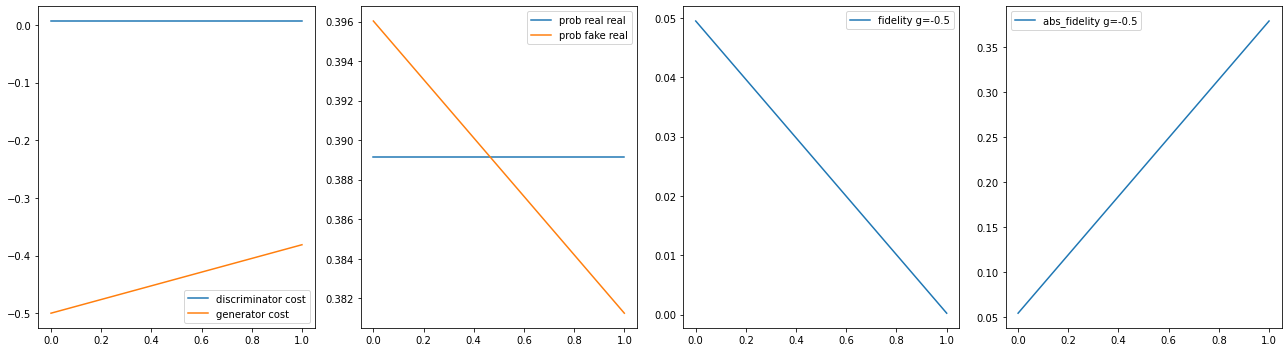

----------- AFTER GENERATOR TRAINING -----------
Epoch 0: generator cost = -0.3812476396560669
Epoch 0: discriminator cost = 0.006861001253128052
Prob(fake classified as real):  0.38124764
Prob(real classified as real):  0.38916504
-------------------------------------
----------- TRAINING DONE -----------


In [34]:
snapshot_interval_epochs = 5
results, json_result = trainer.train(disc_weights,
      gen_weights, 
      opt, 
      epochs=epochs, 
      disc_iteration=disc_iteration, 
      gen_iteration=gen_iteration,
      snapshot_interval_epochs=snapshot_interval_epochs,
      early_stop_fidelity_threshold=None)
res_dict = trainer.get_params_and_results()

In [247]:
trained_gen_pairs = res_dict['weights'][-1]['gen_pairs']
trained_disc_pairs = res_dict['weights'][-1]['disc_pairs']

In [248]:
gen_evaluator = CircuitEvaluator(pure_gen, symbol_value_pairs=trained_gen_pairs)
disc_evaluator = CircuitEvaluator(disc, symbol_value_pairs=trained_disc_pairs)
real_evaluator = CircuitEvaluator(pure_real, real_symbols, trainer.real_values_provider)

In [ ]:
if use_neptune:
        neptune.log_artifact(io.StringIO(disc_evaluator.get_resolved_circuit().to_qasm()), 'desc_qasm.txt')
        neptune.log_artifact(io.StringIO(gen_evaluator.get_resolved_circuit().to_qasm()), 'gen_qasm.txt')
        neptune.log_artifact(io.StringIO(json_result), 'weights.json')

In [ ]:
def get_gen_for_g(g, gen_weights, gen_provider):
    rad = gen_provider(g)
    return np.append(gen_weights, rad)

def get_states_and_fidelty_for_real(gen_evaluator, 
                                    real_evaluator, 
                                    gen_pairs, 
                                    g, 
                                    size):
    generated = gen_evaluator.get_state_from_params(trace_dims=list(range(size)))
    real = real_evaluator.get_state_from_params(g)
    return generated, real, cirq.fidelity(generated, real), cirq.fidelity(abs(generated), abs(real))

def get_states_and_fidelty_for_ground(gen_evaluator, g, gen_weights, size):

    generated = gen_evaluator.get_state_from_params(trace_dims=list(range(size)))
    ground = get_ground_state_for_g(g, size)
    return generated, ground, cirq.fidelity(generated, ground)

def compare_generated_for_g(gen_evaluator, g1, g2, gen_weights, size):
    generated1 = gen_evaluator.get_state_from_params(trace_dims=list(range(size)))
    generated2 = gen_evaluator.get_state_from_params(trace_dims=list(range(size)))
    return generated1, generated2, cirq.fidelity(generated1, generated2)

In [ ]:
def angle_dist(g, phase_angles_provider, weights):
    angles = phase_angles_provider(g)
    z1_rad = 3 * math.pi / 2
    z2_rad = -3 * math.pi / 2
    z1_deg = math.degrees(z1_rad)
    z2_deg = math.degrees(z2_rad)
    
    xr_rad = angles[0]
    xv_rad = angles[1]
    xw_rad = angles[2]
    xr_deg = math.degrees(xr_rad)
    xv_deg = math.degrees(xv_rad)
    xw_deg = math.degrees(xw_rad)
    
    
    norm_w_deg = [math.degrees(w) for w in weights]
    deg_diff = [norm_w_deg[0], z1_deg, norm_w_deg[0] - z1_deg, weights[0], z1_rad]
    
    print(z1_deg,z2_deg,xr_deg,xv_deg,xw_deg)
    return deg_diff

In [ ]:
g = g_values[0]
generated_state, real_state, fidelity, abs_fidelity = get_states_and_fidelty_for_real(gen_evaluator, real_evaluator, trained_gen_pairs, g, data_bus_size)

In [ ]:
generated_state, real_state, fidelity, abs_fidelity

In [ ]:
if use_neptune:
    neptune.log_artifact(io.StringIO(str({"generated_state": generated_state.tolist(), "real_state": real_state.tolist()})), f"states_g={g}.txt")

In [ ]:
if use_neptune:
    neptune.stop()

In [ ]:
get_g_parameters_provider()(g)

In [ ]:
real025 = real_evaluator.get_state_from_params(0.25)

In [ ]:
real04 = real_evaluator.get_state_from_params(0.4)
real01 = real_evaluator.get_state_from_params(0.1)

In [ ]:
cirq.fidelity(real025, -real025)

In [ ]:
compare_generated_for_g(gen_evaluator, -0.9, -0.8, trained_gen_weights, data_bus_size)

In [ ]:
g = 0
get_states_and_fidelty_for_ground(gen_evaluator, g, trained_gen_weights, data_bus_size)

In [27]:
math.e ** - math.log(100)

0.009999999999999998

In [37]:
math.e ** - ((0 + 200) * math.log(100) / 4000 )

0.7943282347242815

In [5]:
cirq.fidelity(np.array([0,1,0,0,0,0,0,0]),np.array([0,0,0,1,0,0,0,0]))

0